## I like cereal, sometimes.
Let's look at some cereal.

I want to investigate calories per serving based on other nutritional information, and rating based on all nutritonal information. I don't have a good reason for doing so. I'm not particularly invested in the result. I'm gonna do it anyway.

In [1]:
# Start with some basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("cereal.csv")
df.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


Cool, that looks like cereal to me. Let's make the data usable.

First, there's a couple columns we don't care about. Drop all of those.

In [2]:
# We'll hold onto the name in case we want to toss it back in later
names = df["name"]
# Get rid of name, manufacturer, type (hot/cold), and display shelf
df = df.drop(columns = ["name", "mfr", "type", "shelf"])
df.head()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,weight,cups,rating
0,70,4,1,130,10.0,5.0,6,280,25,1.0,0.33,68.402973
1,120,3,5,15,2.0,8.0,8,135,0,1.0,1.00,33.983679
2,70,4,1,260,9.0,7.0,5,320,25,1.0,0.33,59.425505
3,50,4,0,140,14.0,8.0,0,330,25,1.0,0.50,93.704912
4,110,2,2,200,1.0,14.0,8,-1,25,1.0,0.75,34.384843


Cool, that looks better. Next, whoever made this dataset named a couple of the columns weird. Let's fix that.

In [3]:
df = df.rename(columns={'carbo': 'carbs', 'potass': 'potassium'})
df.head()

,calories,protein,fat,sodium,fiber,carbs,sugars,potassium,vitamins,weight,cups,rating
0,70,4,1,130,10.0,5.0,6,280,25,1.0,0.33,68.402973
1,120,3,5,15,2.0,8.0,8,135,0,1.0,1.00,33.983679
2,70,4,1,260,9.0,7.0,5,320,25,1.0,0.33,59.425505
3,50,4,0,140,14.0,8.0,0,330,25,1.0,0.50,93.704912
4,110,2,2,200,1.0,14.0,8,-1,25,1.0,0.75,34.384843


That makes more sense. I'm also seeing that there is, apparantly, -1 potassium in almond delight. That's definitely wrong. Unfortunately, it looks like Almond Delight stopped being manufactured in the 90s (which has implications for the dataset I don't really want to get into), and potassium isn't listed on any of the old nutrition facts I can find. My best guess is that for this dataset, -1 means N/A. 

To get a feel for the data, let's look at each of the features graphed against each other.

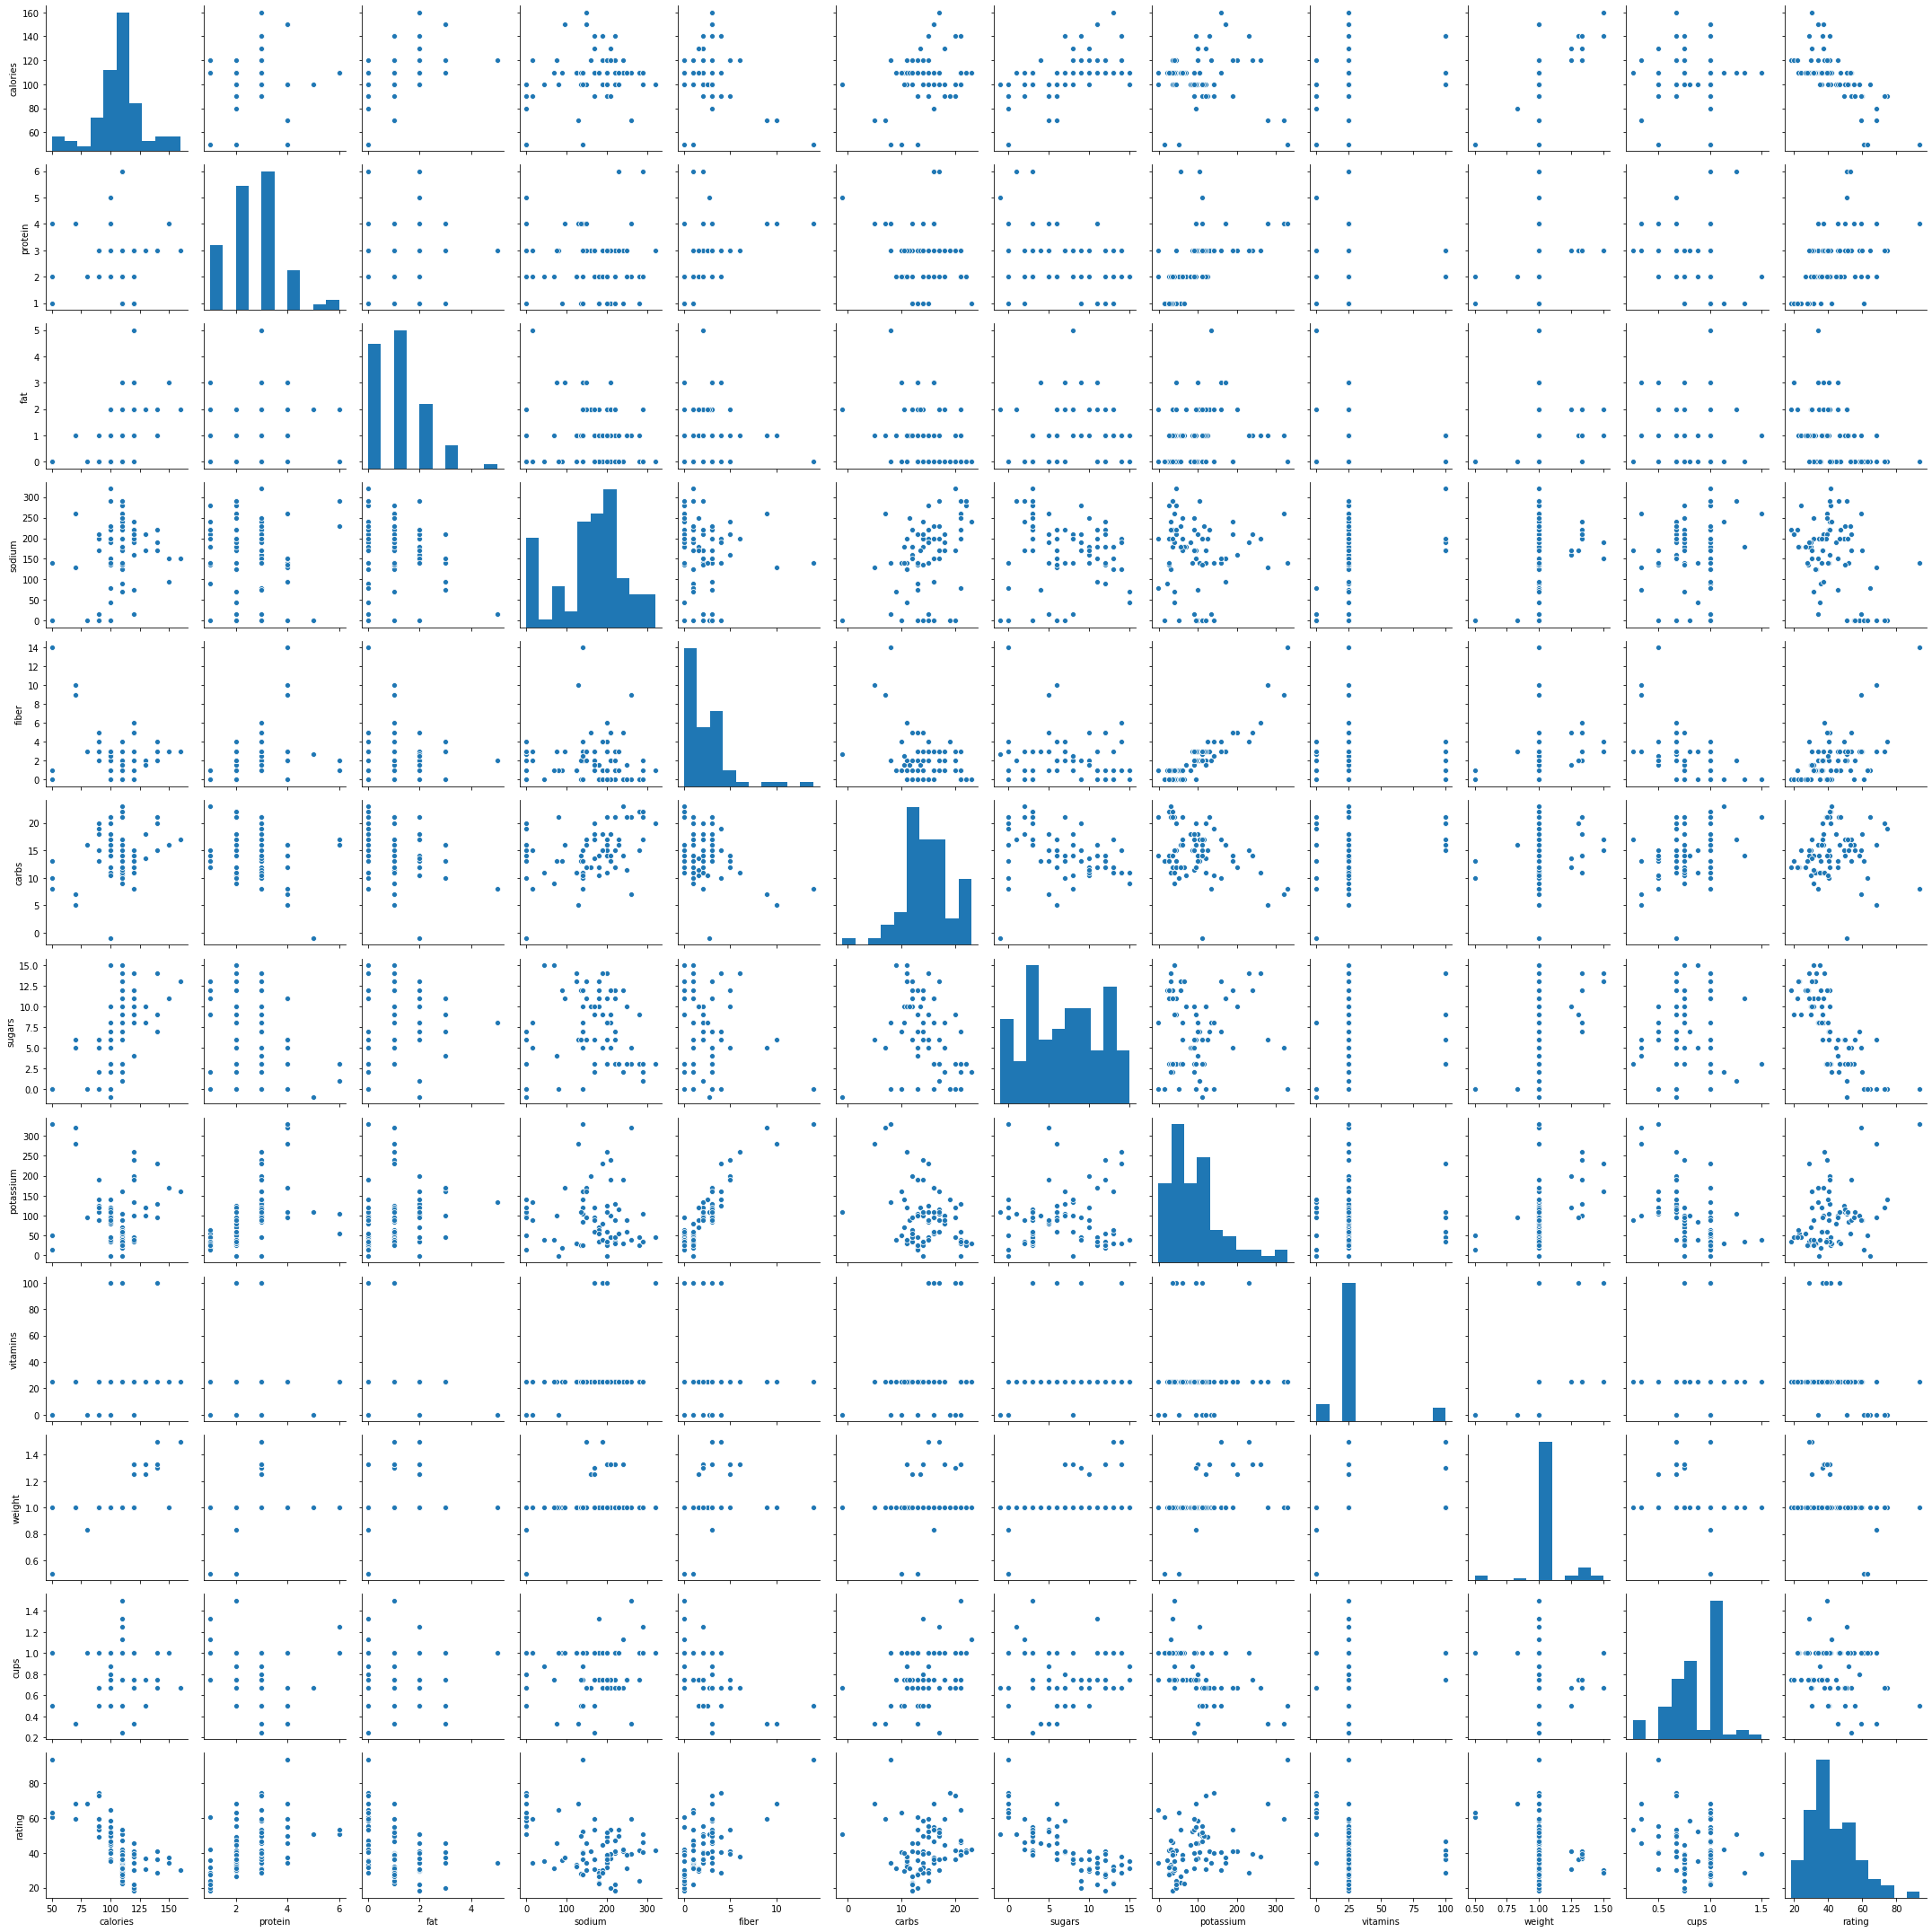

In [4]:
%matplotlib inline
sns.pairplot(df, height=2.5)
plt.tight_layout()

Oh, so that's awful. Since all your classes are Zoom now, I hope you're used to zooming in :))))

Just by looking at the graphs, very few of the features appear to be correlated with eachother. Let's look at correlation on a more quantitative scale.

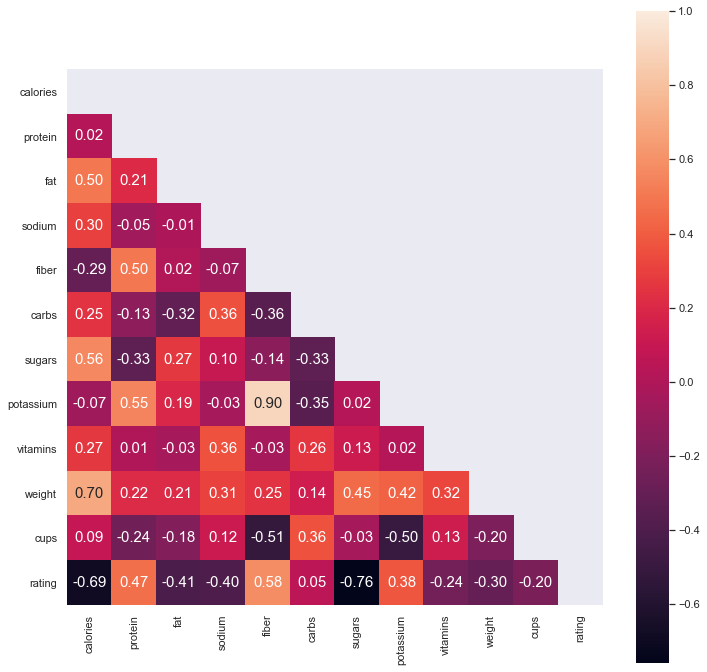

In [5]:
# correlation
cols = df.columns

correlation = df.corr()
sns.set(rc={'figure.figsize':(12,12)})

# we don't need duplicates
mask = np.triu(correlation.corr())

# make a heatmap
sns.heatmap(correlation,
            mask=mask,
            cbar=True,
            annot=True,
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=cols,
            xticklabels=cols)

The columns I'm most interested in here are calories and rating. 

Honestly, a lot of this doesn't fit well with what would be logical (rating inversely related to sugar?), but oh well. It's not my job to verify the legitimacy of cereal.

Now let's try some linear regression. We'll start with calories and rating.

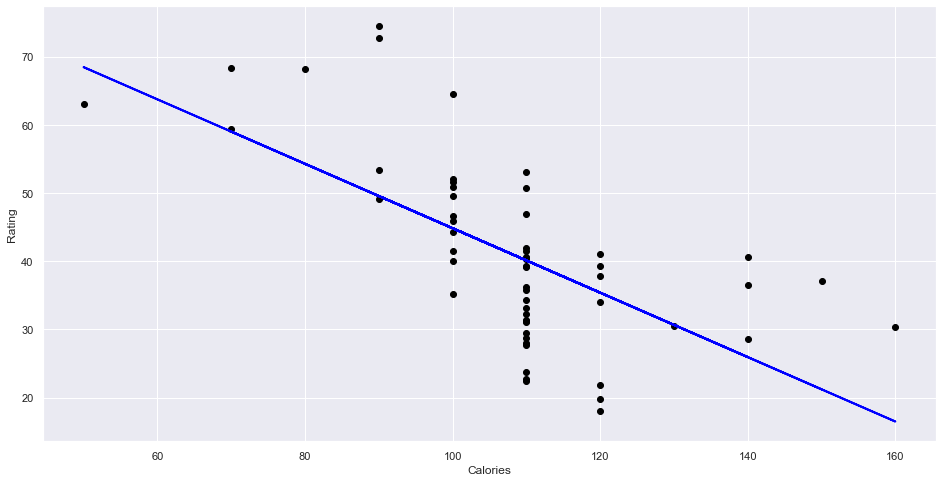

R^2 Score: 0.5193861944245354
Mean Squared Error: 104.12498859947274


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

X = df['calories'].values.reshape(-1,1)
y = df['rating'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

lrm = LinearRegression()
lrm.fit(X_train, y_train)
pred = lrm.predict(X_train)
y_pred = lrm.predict(X_test)

plt.figure(figsize=(16, 8))
plt.scatter(X_train, y_train, c='black')
plt.plot(X_train, pred, c='blue', linewidth=2)
plt.xlabel("Calories")
plt.ylabel("Rating")
plt.show()

r2 = r2_score(y_test, y_pred) # 1.0 is best
mse = mean_squared_error(y_test, y_pred) # 0.0 is best

print("R^2 Score: {}".format(r2))
print("Mean Squared Error: {}".format(mse))

Okay, sure, that looks reasonable. It's not a perfect fit, but a perfect fit doesn't seem possible with this data. We can try Polynomial Regression to see if that's any better.

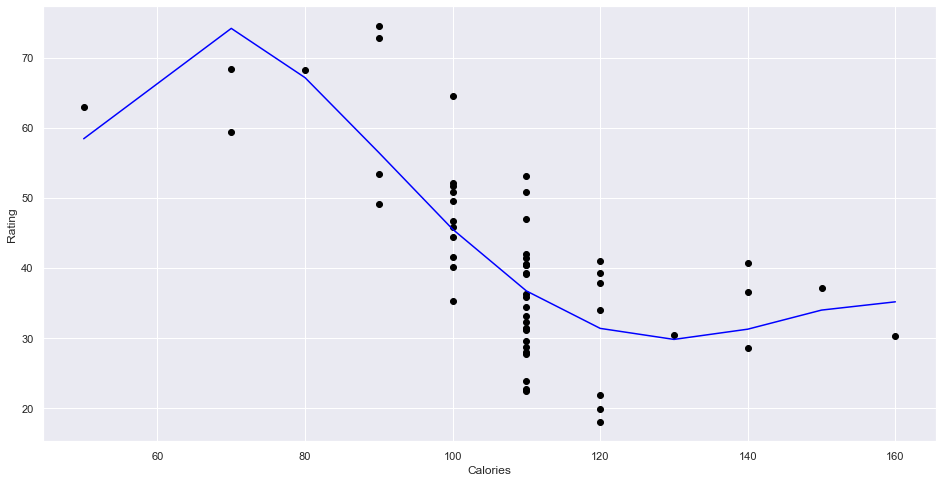

R^2 Score: 0.44575037337130896
Mean Squared Error: 120.0781903983672


In [7]:
from sklearn.preprocessing import PolynomialFeatures

prm = PolynomialFeatures(degree =4)
X_prm = prm.fit_transform(X_train)
prm.fit(X_prm, y_train)
lrm2 = LinearRegression()
lrm2.fit(X_prm, y_train)
lrm_pred = lrm2.predict(X_prm)
new_X, new_y = zip(*sorted(zip(X_train, lrm_pred)))
plt.figure(figsize=(16, 8))
plt.scatter(X_train, y_train, c='black')
plt.plot(new_X, new_y, c='blue')
plt.xlabel("Calories")
plt.ylabel("Rating")
plt.show()

X_test_prm = prm.fit_transform(X_test)
lrm_test_pred = lrm2.predict(X_test_prm)

r2 = r2_score(y_test, lrm_test_pred) # 1.0 is best
mse = mean_squared_error(y_test, lrm_test_pred) # 0.0 is best

print("R^2 Score: {}".format(r2))
print("Mean Squared Error: {}".format(mse))

Admittedly that looks much better. Interestingly enough, though, our metrics describe it as worse. I suppose we'll trust the numbers and stick with the Linear Regression Model.

I want to get a good model out of this, and Calories and Rating aren't as highly correlated as I'd like. Let's do the same thing but with Potassium and Fiber, which according to our correlation heatmap had the highest correlation.

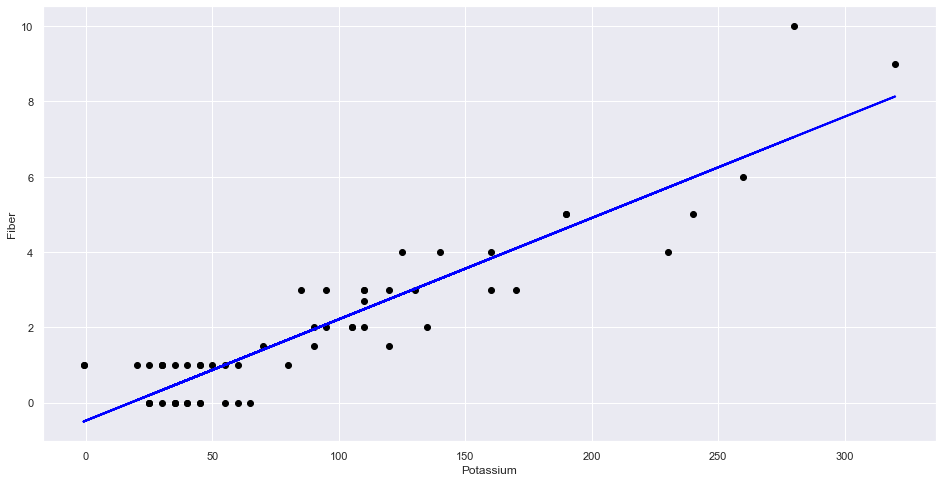

R^2 Score: 0.7441531247248384
Mean Squared Error: 2.2340229340433018


In [8]:
X = df['potassium'].values.reshape(-1,1)
y = df['fiber'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

lrm = LinearRegression()
lrm.fit(X_train, y_train)
pred = lrm.predict(X_train)
y_pred = lrm.predict(X_test)

plt.figure(figsize=(16, 8))
plt.scatter(X_train, y_train, c='black')
plt.plot(X_train, pred, c='blue', linewidth=2)
plt.xlabel("Potassium")
plt.ylabel("Fiber")
plt.show()

r2 = r2_score(y_test, y_pred) # 1.0 is best
mse = mean_squared_error(y_test, y_pred) # 0.0 is best

print("R^2 Score: {}".format(r2))
print("Mean Squared Error: {}".format(mse))

Looks pretty good! With a solid linear regression model (for two of the most boring categories, but I'm not picky), I'm satisfied enough to move on to different models.

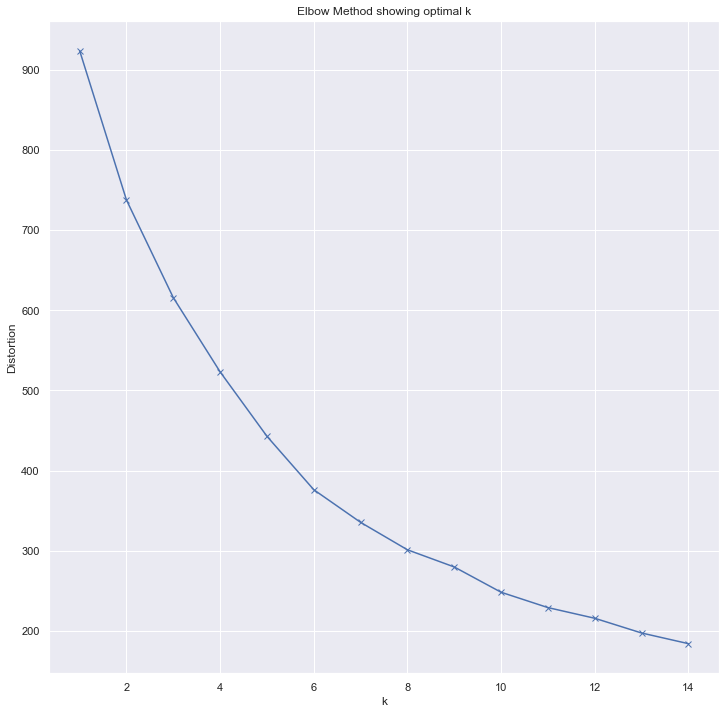

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scalar = StandardScaler()
scalar.fit(df)
X_ss = scalar.fit_transform(df)

sum = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(X_ss)
    sum.append(km.inertia_)

plt.plot(K, sum, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method showing optimal k')
plt.show()

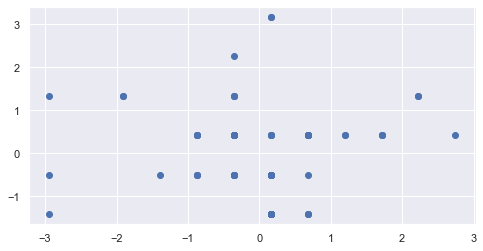

In [10]:
# Let's go with... 12? I've never been good at reading those. 
km = KMeans(n_clusters=12)
km.fit(X_ss)

plt.figure(figsize=(8, 4))
plt.scatter(X_ss[:, 0], X_ss[:, 1])

Alright, cool. I got nothing from that. Instead, let's use PCA to see if we can get something more readable. 

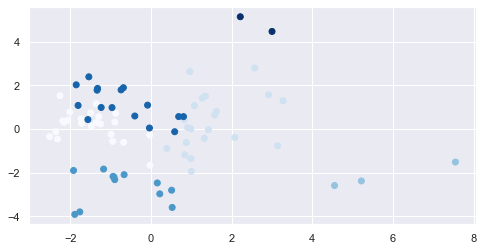

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=12)
X_r = pca.fit_transform(X_ss)

km = KMeans(n_clusters=6)
km.fit(X_r)
y_pred = km.predict(X_r)
plt.figure(figsize=(8, 4))
plt.scatter(X_r[:, 0], X_r[:, 1], c=y_pred, cmap='Blues')

Excellent! Those are some readable clusters. Unfortunately, I still think the linear regression model is the most applicable data model here—probably because not many of the features are highly dependant on more than one other feature. 

# Conclusions

1) The most reliably correlated features are potassium and fiber

2) Of the models I tried, linear regression models suit this data best

2) A reliable linear regression model can be trained on potassium and fiber, and to a lesser extent calories and ratings

3) The person who made the dataset was right when they said this:

#### "If you like to eat cereal, do yourself a favor and avoid this dataset at all costs."